In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/drive/Shareddrives/ACL/MRNet-v1.0'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/Shareddrives/ACL/MRNet-v1.0/valid-abnormal.csv
/content/drive/Shareddrives/ACL/MRNet-v1.0/valid-acl.csv
/content/drive/Shareddrives/ACL/MRNet-v1.0/train-meniscus.csv
/content/drive/Shareddrives/ACL/MRNet-v1.0/valid-meniscus.csv
/content/drive/Shareddrives/ACL/MRNet-v1.0/train-acl.csv
/content/drive/Shareddrives/ACL/MRNet-v1.0/train-abnormal.csv
/content/drive/Shareddrives/ACL/MRNet-v1.0/.DS_Store
/content/drive/Shareddrives/ACL/MRNet-v1.0/train/.DS_Store
/content/drive/Shareddrives/ACL/MRNet-v1.0/train/axial/0034.npy
/content/drive/Shareddrives/ACL/MRNet-v1.0/train/axial/0571.npy
/content/drive/Shareddrives/ACL/MRNet-v1.0/train/axial/0666.npy
/content/drive/Shareddrives/ACL/MRNet-v1.0/train/axial/0912.npy
/content/drive/Shareddrives/ACL/MRNet-v1.0/train/axial/0742.npy
/content/drive/Shareddrives/ACL/MRNet-v1.0/train/axial/0560.npy
/content/drive/Shareddrives/ACL/MRNet-v1.0/train/axial/0323.npy
/content/drive/Shareddrives/ACL/MRNet-v1.0/train/axial/0484.npy
/content/drive

In [ ]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation,MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import numpy as np
import os

import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import SGD 
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.callbacks import *
import numpy as np
import pandas as pd 
from numpy import zeros, newaxis

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

from PIL import Image

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7026214871868286257
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9553871333428517305
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Load Data

In [ ]:
labels_train=[]
labels_train_abnormal = pd.DataFrame.to_numpy(pd.read_csv("/content/drive/Shareddrives/ACL/MRNet-v1.0/train-abnormal.csv")) 
labels_train_acl = pd.DataFrame.to_numpy(pd.read_csv("/content/drive/Shareddrives/ACL/MRNet-v1.0/train-acl.csv")) 
labels_train_men = pd.DataFrame.to_numpy(pd.read_csv("/content/drive/Shareddrives/ACL/MRNet-v1.0/train-meniscus.csv")) 
labels_train.append(1)
labels_train.append(0)
labels_train.append(0)

for i in range (0,1129):
    labels_train.append(labels_train_abnormal[i,1])
    labels_train.append(labels_train_acl[i,1])
    labels_train.append(labels_train_men[i,1])
labels_train=np.array(labels_train).reshape(-1, 3)

labels_test=[]
labels_test_abnormal = pd.DataFrame.to_numpy(pd.read_csv("/content/drive/Shareddrives/ACL/MRNet-v1.0/valid-abnormal.csv")) 
labels_test_acl = pd.DataFrame.to_numpy(pd.read_csv("/content/drive/Shareddrives/ACL/MRNet-v1.0/valid-acl.csv")) 
labels_test_men = pd.DataFrame.to_numpy(pd.read_csv("/content/drive/Shareddrives/ACL/MRNet-v1.0/valid-meniscus.csv")) 
labels_test.append(0)
labels_test.append(0)
labels_test.append(0)

for i in range (119):
    labels_test.append(labels_test_abnormal[i,1])
    labels_test.append(labels_test_acl[i,1])
    labels_test.append(labels_test_men[i,1])
labels_test=np.array(labels_test).reshape(-1, 3)

## Load data into arrays (only run if haven't loaded data before, otherwise reload arrays from files)

In [ ]:
X_Train_ax = []
Y_Train_ax=[]
X_Train_cor=[]
Y_Train_cor=[]
X_Train_sag=[]
Y_Train_sag=[]

for patient_ID in range(1130):
    label=labels_train[patient_ID]
    if(patient_ID<10):
        pathd1='/content/drive/Shareddrives/ACL/MRNet-v1.0/train/' + 'axial/000'+str(patient_ID)+'.npy'
        pathd2='/content/drive/Shareddrives/ACL/MRNet-v1.0/train/' + 'coronal/000'+str(patient_ID)+'.npy'
        pathd3='/content/drive/Shareddrives/ACL/MRNet-v1.0/train/' + 'sagittal/000'+str(patient_ID)+'.npy'
    elif(patient_ID<100):
        pathd1='/content/drive/Shareddrives/ACL/MRNet-v1.0/train/' + 'axial/00'+str(patient_ID)+'.npy'
        pathd2='/content/drive/Shareddrives/ACL/MRNet-v1.0/train/' + 'coronal/00'+str(patient_ID)+'.npy'
        pathd3='/content/drive/Shareddrives/ACL/MRNet-v1.0/train/' + 'sagittal/00'+str(patient_ID)+'.npy'
    elif(patient_ID<1000):
        pathd1='/content/drive/Shareddrives/ACL/MRNet-v1.0/train/' + 'axial/0'+str(patient_ID)+'.npy'
        pathd2='/content/drive/Shareddrives/ACL/MRNet-v1.0/train/' + 'coronal/0'+str(patient_ID)+'.npy'
        pathd3='/content/drive/Shareddrives/ACL/MRNet-v1.0/train/' + 'sagittal/0'+str(patient_ID)+'.npy'
    else:
        pathd1='/content/drive/Shareddrives/ACL/MRNet-v1.0/train/' + 'axial/'+str(patient_ID)+'.npy'
        pathd2='/content/drive/Shareddrives/ACL/MRNet-v1.0/train/' + 'coronal/'+str(patient_ID)+'.npy'
        pathd3='/content/drive/Shareddrives/ACL/MRNet-v1.0/train/' + 'sagittal/'+str(patient_ID)+'.npy'

    d1Image = np.load(pathd1)
    d2Image = np.load(pathd2)
    d3Image = np.load(pathd3)
    startd1=int((d1Image.shape[0]/2)-1)
    endd1=int((d1Image.shape[0]/2)+2)
    startd2=int((d2Image.shape[0]/2)-1)
    endd2=int((d2Image.shape[0]/2)+2)
    startd3=int((d3Image.shape[0]/2)-1)
    endd3=int((d3Image.shape[0]/2)+2)

    
    image_tensor=d1Image[startd1:endd1,:,:].reshape(256,256,3)
    img1 = Image.fromarray(image_tensor[:,:,0])
    img2 = Image.fromarray(image_tensor[:,:,1])
    img3 = Image.fromarray(image_tensor[:,:,2])
    img1_ = img1.resize(size = (224,224))
    img2_ = img2.resize(size = (224,224)) 
    img3_ = img3.resize(size = (224,224))
    i1 = np.asarray(img1_)
    i2 = np.asarray(img2_)
    i3 = np.asarray(img3_)
    img_tensor = np.dstack((i1,i2,i3)) #(224,224,3)
    X_Train_ax.append(img_tensor)
    Y_Train_ax.append(label)
    
    image_tensor2=d2Image[startd2:endd2,:,:].reshape(256,256,3)
    img1 = Image.fromarray(image_tensor2[:,:,0])
    img2 = Image.fromarray(image_tensor2[:,:,1])
    img3 = Image.fromarray(image_tensor2[:,:,2])
    img1_ = img1.resize(size = (224,224))
    img2_ = img2.resize(size = (224,224)) 
    img3_ = img3.resize(size = (224,224))
    i1 = np.asarray(img1_)
    i2 = np.asarray(img2_)
    i3 = np.asarray(img3_)
    img_tensor2 = np.dstack((i1,i2,i3)) #(224,224,3)
    X_Train_cor.append(img_tensor2)
    Y_Train_cor.append(label)
    
    image_tensor3=d3Image[startd3:endd3,:,:].reshape(256,256,3)
    img1 = Image.fromarray(image_tensor3[:,:,0])
    img2 = Image.fromarray(image_tensor3[:,:,1])
    img3 = Image.fromarray(image_tensor3[:,:,2])
    img1_ = img1.resize(size = (224,224))
    img2_ = img2.resize(size = (224,224)) 
    img3_ = img3.resize(size = (224,224))
    i1 = np.asarray(img1_)
    i2 = np.asarray(img2_)
    i3 = np.asarray(img3_)
    img_tensor3 = np.dstack((i1,i2,i3)) #(224,224,3)
    X_Train_sag.append(img_tensor3)
    Y_Train_sag.append(label)
    

    
print(np.asarray(X_Train_ax).shape)
print(np.asarray(Y_Train_ax).shape)
print(np.asarray(X_Train_cor).shape)
print(np.asarray(Y_Train_cor).shape)
print(np.asarray(X_Train_sag).shape)
print(np.asarray(Y_Train_sag).shape)
X_Train_ax = np.array(X_Train_ax)
Y_Train_ax = np.array(Y_Train_ax)
X_Train_cor = np.array(X_Train_cor)
Y_Train_cor = np.array(Y_Train_cor)
X_Train_sag = np.array(X_Train_sag)
Y_Train_sag = np.array(Y_Train_sag)

KeyboardInterrupt: ignored

In [ ]:
X_Test_ax = []
Y_Test_ax=[]
X_Test_cor=[]
Y_Test_cor=[]
X_Test_sag=[]
Y_Test_sag=[]

for patient_ID in range(120):
    label=labels_test[patient_ID]
    patient_ID=1130+patient_ID
    if(patient_ID<10):
        pathd1='/content/drive/Shareddrives/ACL/MRNet-v1.0/valid/' + 'axial/000'+str(patient_ID)+'.npy'
        pathd2='/content/drive/Shareddrives/ACL/MRNet-v1.0/valid/' + 'coronal/000'+str(patient_ID)+'.npy'
        pathd3='/content/drive/Shareddrives/ACL/MRNet-v1.0/valid/' + 'sagittal/000'+str(patient_ID)+'.npy'
    elif(patient_ID<100):
        pathd1='/content/drive/Shareddrives/ACL/MRNet-v1.0/valid/' + 'axial/00'+str(patient_ID)+'.npy'
        pathd2='/content/drive/Shareddrives/ACL/MRNet-v1.0/valid/' + 'coronal/00'+str(patient_ID)+'.npy'
        pathd3='/content/drive/Shareddrives/ACL/MRNet-v1.0/valid/' + 'sagittal/00'+str(patient_ID)+'.npy'
    elif(patient_ID<1000):
        pathd1='/content/drive/Shareddrives/ACL/MRNet-v1.0/valid/' + 'axial/0'+str(patient_ID)+'.npy'
        pathd2='/content/drive/Shareddrives/ACL/MRNet-v1.0/valid/' + 'coronal/0'+str(patient_ID)+'.npy'
        pathd3='/content/drive/Shareddrives/ACL/MRNet-v1.0/valid/' + 'sagittal/0'+str(patient_ID)+'.npy'
    else:
        pathd1='/content/drive/Shareddrives/ACL/MRNet-v1.0/valid/' + 'axial/'+str(patient_ID)+'.npy'
        pathd2='/content/drive/Shareddrives/ACL/MRNet-v1.0/valid/' + 'coronal/'+str(patient_ID)+'.npy'
        pathd3='/content/drive/Shareddrives/ACL/MRNet-v1.0/valid/' + 'sagittal/'+str(patient_ID)+'.npy'

    d1Image = np.load(pathd1)
    d2Image = np.load(pathd2)
    d3Image = np.load(pathd3)
    startd1=int((d1Image.shape[0]/2)-1)
    endd1=int((d1Image.shape[0]/2)+2)
    startd2=int((d2Image.shape[0]/2)-1)
    endd2=int((d2Image.shape[0]/2)+2)
    startd3=int((d3Image.shape[0]/2)-1)
    endd3=int((d3Image.shape[0]/2)+2)

    
    image_tensor=d1Image[startd1:endd1,:,:].reshape(256,256,3)
    img1 = Image.fromarray(image_tensor[:,:,0])
    img2 = Image.fromarray(image_tensor[:,:,1])
    img3 = Image.fromarray(image_tensor[:,:,2])
    img1_ = img1.resize(size = (224,224))
    img2_ = img2.resize(size = (224,224)) 
    img3_ = img3.resize(size = (224,224))
    i1 = np.asarray(img1_)
    i2 = np.asarray(img2_)
    i3 = np.asarray(img3_)
    img_tensor = np.dstack((i1,i2,i3)) #(224,224,3)
    X_Test_ax.append(img_tensor)
    Y_Test_ax.append(label)
    
    image_tensor2=d2Image[startd2:endd2,:,:].reshape(256,256,3)
    img1 = Image.fromarray(image_tensor2[:,:,0])
    img2 = Image.fromarray(image_tensor2[:,:,1])
    img3 = Image.fromarray(image_tensor2[:,:,2])
    img1_ = img1.resize(size = (224,224))
    img2_ = img2.resize(size = (224,224)) 
    img3_ = img3.resize(size = (224,224))
    i1 = np.asarray(img1_)
    i2 = np.asarray(img2_)
    i3 = np.asarray(img3_)
    img_tensor2 = np.dstack((i1,i2,i3)) #(224,224,3)
    X_Test_cor.append(img_tensor2)
    Y_Test_cor.append(label)
    
    image_tensor3=d3Image[startd3:endd3,:,:].reshape(256,256,3)
    img1 = Image.fromarray(image_tensor3[:,:,0])
    img2 = Image.fromarray(image_tensor3[:,:,1])
    img3 = Image.fromarray(image_tensor3[:,:,2])
    img1_ = img1.resize(size = (224,224))
    img2_ = img2.resize(size = (224,224)) 
    img3_ = img3.resize(size = (224,224))
    i1 = np.asarray(img1_)
    i2 = np.asarray(img2_)
    i3 = np.asarray(img3_)
    img_tensor3 = np.dstack((i1,i2,i3)) #(224,224,3)
    X_Test_sag.append(img_tensor3)
    Y_Test_sag.append(label)

    
    
    
print(np.asarray(X_Test_ax).shape)
print(np.asarray(Y_Test_ax).shape)
print(np.asarray(X_Test_cor).shape)
print(np.asarray(Y_Test_cor).shape)
print(np.asarray(X_Test_sag).shape)
print(np.asarray(Y_Test_sag).shape)
X_Test_ax = np.array(X_Test_ax)
Y_Test_ax = np.array(Y_Test_ax)
X_Test_cor = np.array(X_Test_cor)
Y_Test_cor = np.array(Y_Test_cor)
X_Test_sag = np.array(X_Test_sag)
Y_Test_sag = np.array(Y_Test_sag)

In [ ]:
np.save('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/X_Train_ax.npy', X_Train_ax)
np.save('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/Y_Train_ax.npy', Y_Train_ax)
np.save('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/X_Train_cor.npy', X_Train_cor)
np.save('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/Y_Train_cor.npy', Y_Train_cor)
np.save('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/X_Train_sag.npy', X_Train_sag)
np.save('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/Y_Train_sag.npy', Y_Train_sag)
np.save('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/X_Test_ax.npy', X_Test_ax)
np.save('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/Y_Test_ax.npy', Y_Test_ax)
np.save('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/X_Test_cor.npy', X_Test_cor)
np.save('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/Y_Test_cor.npy', Y_Test_cor)
np.save('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/X_Test_sag.npy', X_Test_sag)
np.save('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/Y_Test_sag.npy', Y_Test_sag)

## Reload saved numpy arrays

In [ ]:
X_Train_ax =  np.load('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/X_Train_ax.npy')
Y_Train_ax = np.load('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/Y_Train_ax.npy')
X_Train_cor = np.load('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/X_Train_cor.npy')
Y_Train_cor = np.load('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/Y_Train_cor.npy')
X_Train_sag = np.load('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/X_Train_sag.npy')
Y_Train_sag = np.load('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/Y_Train_sag.npy')
X_Test_ax = np.load('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/X_Test_ax.npy')
Y_Test_ax = np.load('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/Y_Test_ax.npy')
X_Test_cor = np.load('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/X_Test_cor.npy')
Y_Test_cor = np.load('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/Y_Test_cor.npy')
X_Test_sag = np.load('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/X_Test_sag.npy')
Y_Test_sag = np.load('/content/drive/MyDrive/Colab Notebooks/MRNet/Data np/Y_Test_sag.npy')
print('Train arrays shape')
print(np.asarray(X_Train_ax).shape)
print(np.asarray(Y_Train_ax).shape)
print(np.asarray(X_Train_cor).shape)
print(np.asarray(Y_Train_cor).shape)
print(np.asarray(X_Train_sag).shape)
print(np.asarray(Y_Train_sag).shape)
print('Test arrays shape')
print(np.asarray(X_Test_ax).shape)
print(np.asarray(Y_Test_ax).shape)
print(np.asarray(X_Test_cor).shape)
print(np.asarray(Y_Test_cor).shape)
print(np.asarray(X_Test_sag).shape)
print(np.asarray(Y_Test_sag).shape)

Train arrays shape
(1130, 224, 224, 3)
(1130, 3)
(1130, 224, 224, 3)
(1130, 3)
(1130, 224, 224, 3)
(1130, 3)
Test arrays shape
(120, 224, 224, 3)
(120, 3)
(120, 224, 224, 3)
(120, 3)
(120, 224, 224, 3)
(120, 3)


## Divide data into sets for each plane

In [ ]:
Y_Test_ax_ab=Y_Test_ax[:,0]
Y_Train_ax_ab=Y_Train_ax[:,0]
Y_Test_ax_acl=Y_Test_ax[:,1]
Y_Train_ax_acl=Y_Train_ax[:,1]
Y_Test_ax_men=Y_Test_ax[:,2]
Y_Train_ax_men=Y_Train_ax[:,2]

Y_Test_cor_ab=Y_Test_cor[:,0]
Y_Train_cor_ab=Y_Train_cor[:,0]
Y_Test_cor_acl=Y_Test_cor[:,1]
Y_Train_cor_acl=Y_Train_cor[:,1]
Y_Test_cor_men=Y_Test_cor[:,2]
Y_Train_cor_men=Y_Train_cor[:,2]

Y_Test_sag_ab=Y_Test_sag[:,0]
Y_Train_sag_ab=Y_Train_sag[:,0]
Y_Test_sag_acl=Y_Test_sag[:,1]
Y_Train_sag_acl=Y_Train_sag[:,1]
Y_Test_sag_men=Y_Test_sag[:,2]
Y_Train_sag_men=Y_Train_sag[:,2]

# Prepare Efficientnetv2 Model

In [ ]:
!pip install tensorflow_addons

import os
import sys

# Download source code.
if "efficientnetv2" not in os.getcwd():
  !git clone --depth 1 https://github.com/google/automl
  os.chdir('automl/efficientnetv2')
  sys.path.append('.')
else:
  !git pull

def download(m):
  if m not in os.listdir():
    !wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/v2/{m}.tgz
    !tar zxf {m}.tgz
  ckpt_path = os.path.join(os.getcwd(), m)
  return ckpt_path

fatal: destination path 'automl' already exists and is not an empty directory.


In [ ]:
!pip install h5py pyyaml #to save file in h5

In [ ]:
import effnetv2_model

In [ ]:
epoch = 100
batchSize = 16

In [ ]:
epochs=[0]*epoch
for i in range(0,epoch):
  epochs[i]=i

In [ ]:
def plot_graphs(y):
  plt.plot( epochs,y.history['accuracy'],'r')
  plt.xlabel("Epochs")
  plt.ylabel("acc")
  plt.title("Accuracy vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['val_accuracy'],'b')
  plt.xlabel("Epochs")
  plt.ylabel("val_acc")
  plt.title("Validation Acuracy vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['loss'],'g')
  plt.xlabel("Epochs")
  plt.ylabel("loss")
  plt.title("Loss vs Epochs")
  plt.show()

  plt.plot( epochs,y.history['val_loss'],'k')
  plt.xlabel("Epochs")
  plt.ylabel("val_loss")
  plt.title("Validation Loss vs Epochs")
  plt.show()

# EfficientNetv2 B0

In [ ]:
MODEL = 'efficientnetv2-b0'  #@param
effnet_layer = effnetv2_model.get_model('efficientnetv2-b0')

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


## Model axial acl

### Create and train model

In [ ]:
model_ax_acl = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
    effnet_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
])

In [ ]:
model_ax_acl.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),metrics=["accuracy"])

Epoch 1/100
35/35 [==============================] - 16s 219ms/step - loss: 0.2902 - accuracy: 0.8987 - val_loss: 0.8016 - val_accuracy: 0.7647
Epoch 2/100
35/35 [==============================] - 6s 174ms/step - loss: 0.0283 - accuracy: 0.9973 - val_loss: 0.8266 - val_accuracy: 0.7353
Epoch 3/100
35/35 [==============================] - 6s 176ms/step - loss: 0.0232 - accuracy: 1.0000 - val_loss: 0.8420 - val_accuracy: 0.7941
Epoch 4/100
35/35 [==============================] - 6s 177ms/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.8823 - val_accuracy: 0.7941
Epoch 5/100
35/35 [==============================] - 6s 179ms/step - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.8963 - val_accuracy: 0.7941
Epoch 6/100
35/35 [==============================] - 6s 178ms/step - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.9645 - val_accuracy: 0.7647
Epoch 7/100
35/35 [==============================] - 6s 176ms/step - loss: 0.0237 - accuracy: 0.9991 - val_loss: 0.9424 - val_accuracy: 0.764

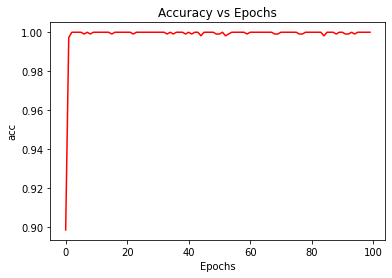

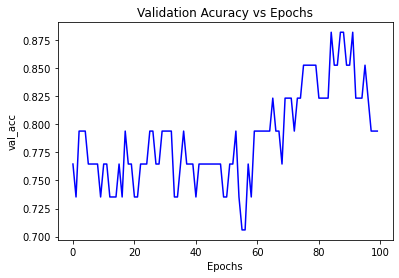

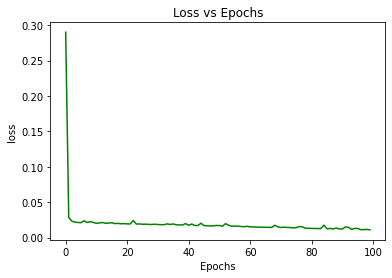

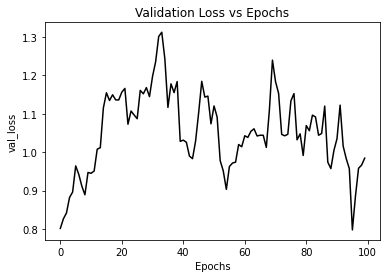

CPU times: user 9min 54s, sys: 9.58 s, total: 10min 4s
Wall time: 10min 30s


In [ ]:
%%time
ax_acl_his = model_ax_acl.fit(X_Train_ax, Y_Train_ax_acl, epochs = epoch, 
          shuffle=True, validation_split=0.03, batch_size=batchSize)

plot_graphs(ax_acl_his)

In [ ]:
model_ax_acl.save_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_ax_acl_b0.h5')

### Reload model (if alr trained)

In [ ]:
model_ax_aclR = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
    effnet_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_ax_aclR.load_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_ax_acl_b0.h5')

### Test model

In [ ]:
preds_ax_acl = model_ax_acl.predict(X_Test_ax)

In [ ]:
accuracy_score(Y_Test_ax_acl, np.rint(preds_ax_acl).astype(int))

0.725

In [ ]:
f1_score(Y_Test_ax_acl, np.rint(preds_ax_acl).astype(int), average='binary')

0.6292134831460674

In [ ]:
recall_score(Y_Test_ax_acl, np.rint(preds_ax_acl).astype(int), average='binary')

0.5185185185185185

In [ ]:
precision_score(Y_Test_ax_acl, np.rint(preds_ax_acl).astype(int), average='binary')

0.8

## Model coronal acl

### Create and prepare model

In [ ]:
model_cor_acl = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[224, 224, None]),
    effnet_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
])

In [ ]:
model_cor_acl.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),metrics=["accuracy"])

Epoch 1/100
35/35 [==============================] - 16s 217ms/step - loss: 0.0391 - accuracy: 0.9945 - val_loss: 2.1934 - val_accuracy: 0.7647
Epoch 2/100
35/35 [==============================] - 6s 173ms/step - loss: 0.0218 - accuracy: 1.0000 - val_loss: 2.3979 - val_accuracy: 0.7647
Epoch 3/100
35/35 [==============================] - 6s 174ms/step - loss: 0.0219 - accuracy: 0.9991 - val_loss: 2.5140 - val_accuracy: 0.7647
Epoch 4/100
35/35 [==============================] - 6s 176ms/step - loss: 0.0328 - accuracy: 0.9982 - val_loss: 2.3075 - val_accuracy: 0.7647
Epoch 5/100
35/35 [==============================] - 6s 177ms/step - loss: 0.0209 - accuracy: 0.9991 - val_loss: 2.4328 - val_accuracy: 0.7647
Epoch 6/100
35/35 [==============================] - 6s 178ms/step - loss: 0.0231 - accuracy: 0.9973 - val_loss: 2.2784 - val_accuracy: 0.7647
Epoch 7/100
35/35 [==============================] - 6s 176ms/step - loss: 0.0232 - accuracy: 0.9982 - val_loss: 2.4549 - val_accuracy: 0.764

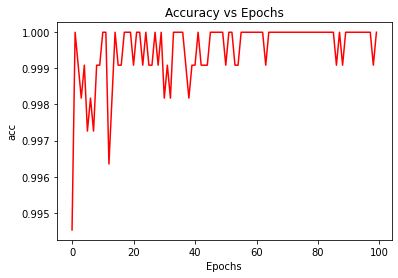

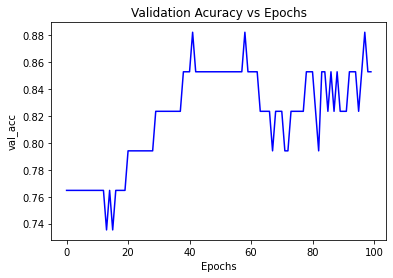

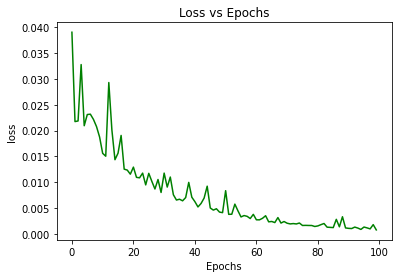

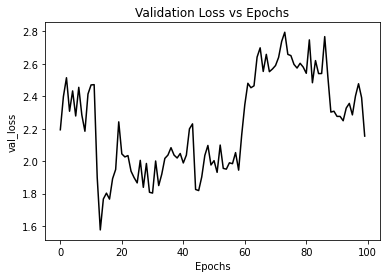

CPU times: user 9min 54s, sys: 9.72 s, total: 10min 4s
Wall time: 10min 18s


In [ ]:
%%time
cor_acl_his = model_cor_acl.fit(X_Train_cor, Y_Train_cor_acl, epochs = epoch, 
          shuffle=True, validation_split=0.03, batch_size=batchSize)
plot_graphs(cor_acl_his)

In [ ]:
model_cor_acl.save_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_cor_acl_b0.h5')

### Reload model

In [ ]:
model_cor_aclR = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[224, 224, None]),
    effnet_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_cor_aclR.load_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_cor_acl_b0.h5')

### Test model

In [ ]:
preds_cor_acl = model_cor_acl.predict(X_Test_cor)

In [ ]:
accuracy_score(Y_Test_cor_acl, np.rint(preds_cor_acl).astype(int))

0.7083333333333334

In [ ]:
f1_score(Y_Test_cor_acl, np.rint(preds_cor_acl).astype(int), average='binary')

0.5977011494252873

In [ ]:
recall_score(Y_Test_cor_acl, np.rint(preds_cor_acl).astype(int), average='binary')

0.48148148148148145

In [ ]:
precision_score(Y_Test_cor_acl, np.rint(preds_cor_acl).astype(int), average='binary')

0.7878787878787878

## Model sagittal acl

### Create and prepare model

In [ ]:
model_sag_acl = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
    effnet_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)),
])

In [ ]:
model_sag_acl.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),metrics=["accuracy"])

Epoch 1/100
35/35 [==============================] - 18s 219ms/step - loss: 0.4407 - accuracy: 0.8750 - val_loss: 1.8156 - val_accuracy: 0.8235
Epoch 2/100
35/35 [==============================] - 6s 172ms/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 1.7705 - val_accuracy: 0.8235
Epoch 3/100
35/35 [==============================] - 6s 174ms/step - loss: 0.0203 - accuracy: 1.0000 - val_loss: 1.7397 - val_accuracy: 0.8235
Epoch 4/100
35/35 [==============================] - 6s 176ms/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 1.7598 - val_accuracy: 0.8235
Epoch 5/100
35/35 [==============================] - 6s 177ms/step - loss: 0.0223 - accuracy: 0.9991 - val_loss: 1.7580 - val_accuracy: 0.8235
Epoch 6/100
35/35 [==============================] - 6s 177ms/step - loss: 0.0196 - accuracy: 1.0000 - val_loss: 1.6844 - val_accuracy: 0.8235
Epoch 7/100
35/35 [==============================] - 6s 176ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 1.7469 - val_accuracy: 0.794

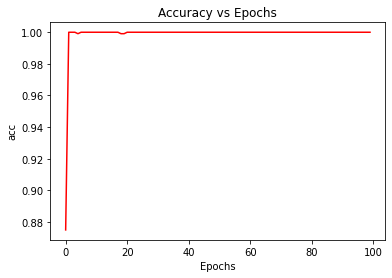

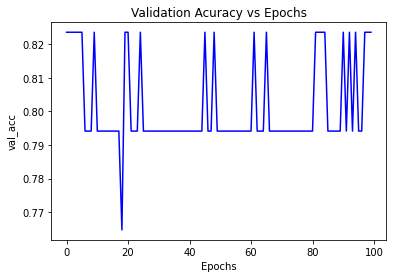

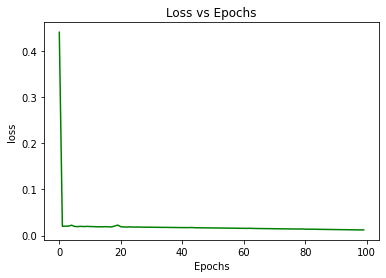

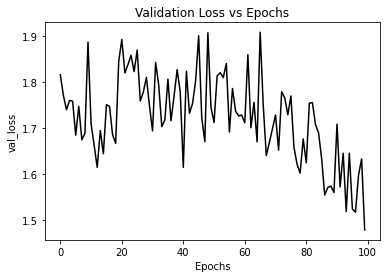

CPU times: user 9min 55s, sys: 9.45 s, total: 10min 5s
Wall time: 10min 32s


In [ ]:
%%time
sag_acl_his = model_sag_acl.fit(X_Train_sag, Y_Train_sag_acl, epochs = epoch, 
          shuffle=True, validation_split=0.03, batch_size=batchSize)
plot_graphs(sag_acl_his)

In [ ]:
model_sag_acl.save_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_sag_acl_b0.h5')

### Reload model

In [ ]:
model_sag_aclR = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
    effnet_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_sag_aclR.load_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_sag_acl_b0.h5')

### Test model

In [ ]:
preds_sag_acl = model_sag_acl.predict(X_Test_sag)

In [ ]:
accuracy_score(Y_Test_sag_acl, np.rint(preds_sag_acl).astype(int))

0.7416666666666667

In [ ]:
f1_score(Y_Test_sag_acl, np.rint(preds_sag_acl).astype(int), average='binary')

0.651685393258427

In [ ]:
recall_score(Y_Test_sag_acl, np.rint(preds_sag_acl).astype(int), average='binary')

0.5370370370370371

In [ ]:
precision_score(Y_Test_sag_acl, np.rint(preds_sag_acl).astype(int), average='binary')

0.8285714285714286

## Overal results

In [ ]:
preds = ((np.rint((preds_sag_acl+preds_ax_acl+preds_cor_acl)).astype(int)).astype(bool)).astype(int)

In [ ]:
accuracy_score(labels_test[:,1], preds)

0.8333333333333334

In [ ]:
f1_score(labels_test[:,1], preds, average='binary')

0.8333333333333334

In [ ]:
precision_score(labels_test[:,1], preds, average='binary')

0.7575757575757576

In [ ]:
recall_score(labels_test[:,1], preds, average='binary')

0.9259259259259259

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(labels_test[:,1], preds)

0.8417508417508418

# EfficientNetv2 S

In [ ]:
MODEL = 'efficientnetv2-S'  #@param
effnet_layer_s = effnetv2_model.get_model('efficientnetv2-s')

317636608/317633552 [==============================] - 2s 0us/step
Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [ ]:
epoch = 20
batchSize = 16

In [ ]:
epochs=[0]*epoch
for i in range(0,epoch):
  epochs[i]=i

## Reshape images

In [ ]:
X_Train_ax_t = []
X_Train_cor_t = []
X_Train_sag_t = []
X_Test_ax_t = []
X_Test_cor_t = []
X_Test_sag_t = [] 
for i in range(1130):
  img1 = Image.fromarray(X_Train_ax[i,:,:,0])
  img2 = Image.fromarray(X_Train_ax[i,:,:,1])
  img3 = Image.fromarray(X_Train_ax[i,:,:,2])
  img1_ = img1.resize(size = (384,384))
  img2_ = img2.resize(size = (384,384)) 
  img3_ = img3.resize(size = (384,384))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Train_ax_t.append(img_tensor)

  img1 = Image.fromarray(X_Train_cor[i,:,:,0])
  img2 = Image.fromarray(X_Train_cor[i,:,:,1])
  img3 = Image.fromarray(X_Train_cor[i,:,:,2])
  img1_ = img1.resize(size = (384,384))
  img2_ = img2.resize(size = (384,384)) 
  img3_ = img3.resize(size = (384,384))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Train_cor_t.append(img_tensor)

  img1 = Image.fromarray(X_Train_sag[i,:,:,0])
  img2 = Image.fromarray(X_Train_sag[i,:,:,1])
  img3 = Image.fromarray(X_Train_sag[i,:,:,2])
  img1_ = img1.resize(size = (384,384))
  img2_ = img2.resize(size = (384,384)) 
  img3_ = img3.resize(size = (384,384))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Train_sag_t.append(img_tensor)
for i in range(120):
  img1 = Image.fromarray(X_Test_ax[i,:,:,0])
  img2 = Image.fromarray(X_Test_ax[i,:,:,1])
  img3 = Image.fromarray(X_Test_ax[i,:,:,2])
  img1_ = img1.resize(size = (384,384))
  img2_ = img2.resize(size = (384,384)) 
  img3_ = img3.resize(size = (384,384))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Test_ax_t.append(img_tensor)

  img1 = Image.fromarray(X_Test_cor[i,:,:,0])
  img2 = Image.fromarray(X_Test_cor[i,:,:,1])
  img3 = Image.fromarray(X_Test_cor[i,:,:,2])
  img1_ = img1.resize(size = (384,384))
  img2_ = img2.resize(size = (384,384)) 
  img3_ = img3.resize(size = (384,384))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Test_cor_t.append(img_tensor)

  img1 = Image.fromarray(X_Test_sag[i,:,:,0])
  img2 = Image.fromarray(X_Test_sag[i,:,:,1])
  img3 = Image.fromarray(X_Test_sag[i,:,:,2])
  img1_ = img1.resize(size = (384,384))
  img2_ = img2.resize(size = (384,384)) 
  img3_ = img3.resize(size = (384,384))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Test_sag_t.append(img_tensor)


X_Train_ax = np.asarray(X_Train_ax_t)
X_Train_cor = np.asarray(X_Train_cor_t)
X_Train_sag = np.asarray(X_Train_sag_t)
X_Test_ax = np.asarray(X_Test_ax_t)
X_Test_cor = np.asarray(X_Test_cor_t)
X_Test_sag = np.asarray(X_Test_sag_t)

print('Train arrays shape')
print(np.asarray(X_Train_ax).shape)
print(np.asarray(Y_Train_ax).shape)
print(np.asarray(X_Train_cor).shape)
print(np.asarray(Y_Train_cor).shape)
print(np.asarray(X_Train_sag).shape)
print(np.asarray(Y_Train_sag).shape)
print('Test arrays shape')
print(np.asarray(X_Test_ax).shape)
print(np.asarray(Y_Test_ax).shape)
print(np.asarray(X_Test_cor).shape)
print(np.asarray(Y_Test_cor).shape)
print(np.asarray(X_Test_sag).shape)
print(np.asarray(Y_Test_sag).shape)

Train arrays shape
(1130, 384, 384, 3)
(1130, 3)
(1130, 384, 384, 3)
(1130, 3)
(1130, 384, 384, 3)
(1130, 3)
Test arrays shape
(120, 384, 384, 3)
(120, 3)
(120, 384, 384, 3)
(120, 3)
(120, 384, 384, 3)
(120, 3)


## Model axial acl

### Create and train model

In [ ]:
model_ax_acl_s = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[384, 384, 3]),
    effnet_layer_s,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
])

In [ ]:
model_ax_acl_s.compile(loss='binary_crossentropy',
              optimizer='Nadam',metrics=["accuracy"])

Epoch 1/20
69/69 [==============================] - 88s 720ms/step - loss: 0.4791 - accuracy: 0.8203 - val_loss: 0.5171 - val_accuracy: 0.9118
Epoch 2/20
69/69 [==============================] - 46s 671ms/step - loss: 0.1347 - accuracy: 0.9544 - val_loss: 0.7758 - val_accuracy: 0.8529
Epoch 3/20
69/69 [==============================] - 47s 675ms/step - loss: 0.0268 - accuracy: 0.9973 - val_loss: 1.0985 - val_accuracy: 0.8824
Epoch 4/20
69/69 [==============================] - 46s 669ms/step - loss: 0.0211 - accuracy: 0.9982 - val_loss: 0.9930 - val_accuracy: 0.8824
Epoch 5/20
69/69 [==============================] - 46s 669ms/step - loss: 0.0159 - accuracy: 0.9991 - val_loss: 1.2181 - val_accuracy: 0.8824
Epoch 6/20
69/69 [==============================] - 46s 673ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 1.3102 - val_accuracy: 0.8824
Epoch 7/20
69/69 [==============================] - 46s 673ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 1.4008 - val_accuracy: 0.8824

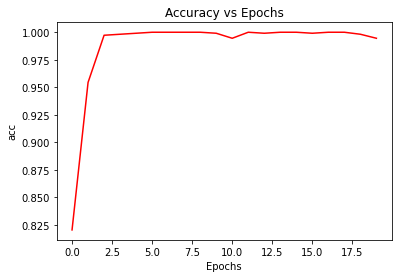

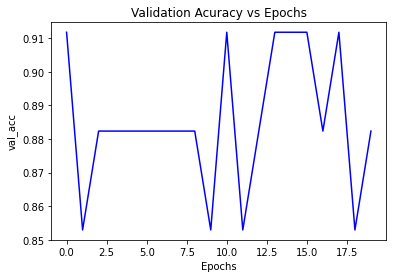

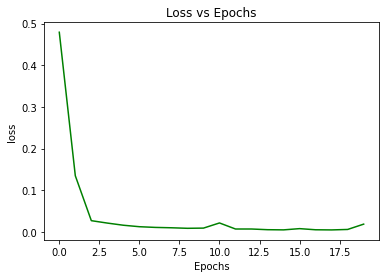

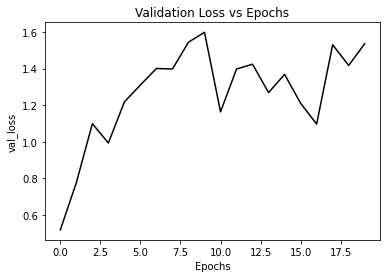

CPU times: user 11min 55s, sys: 3min, total: 14min 56s
Wall time: 17min


In [ ]:
%%time
ax_acl_s_his = model_ax_acl_s.fit(X_Train_ax, Y_Train_ax_acl, epochs = epoch, 
          shuffle=True, validation_split=0.03, batch_size=batchSize)

plot_graphs(ax_acl_s_his)

In [ ]:
model_ax_acl_s.save_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_ax_acl_s.h5')

### Reload model (if alr trained)

In [ ]:
model_ax_acl_sR = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[384, 384, 3]),
    effnet_layer_s,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_ax_acl_sR.load_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_ax_acl_s.h5')

### Test model

In [ ]:
preds_ax_acl_s = model_ax_acl_sR.predict(X_Test_ax)

In [ ]:
accuracy_score(Y_Test_ax_acl, np.rint(preds_ax_acl_s).astype(int))

0.7666666666666667

In [ ]:
f1_score(Y_Test_ax_acl, np.rint(preds_ax_acl_s).astype(int), average='binary')

0.6888888888888889

In [ ]:
recall_score(Y_Test_ax_acl, np.rint(preds_ax_acl_s).astype(int), average='binary')

0.5740740740740741

In [ ]:
precision_score(Y_Test_ax_acl, np.rint(preds_ax_acl_s).astype(int), average='binary')

0.8611111111111112

## Model coronal acl

### Create and train model

In [ ]:
model_cor_acl_s = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[384, 384, 3]),
    effnet_layer_s,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
])

In [ ]:
model_cor_acl_s.compile(loss='binary_crossentropy',
              optimizer='Nadam',metrics=["accuracy"])

Epoch 1/20
69/69 [==============================] - 90s 723ms/step - loss: 0.2257 - accuracy: 0.9215 - val_loss: 0.8854 - val_accuracy: 0.7941
Epoch 2/20
69/69 [==============================] - 46s 668ms/step - loss: 0.0296 - accuracy: 0.9954 - val_loss: 1.4741 - val_accuracy: 0.7941
Epoch 3/20
69/69 [==============================] - 47s 675ms/step - loss: 0.0179 - accuracy: 0.9991 - val_loss: 1.5448 - val_accuracy: 0.7941
Epoch 4/20
69/69 [==============================] - 46s 670ms/step - loss: 0.0147 - accuracy: 0.9982 - val_loss: 0.9420 - val_accuracy: 0.8235
Epoch 5/20
69/69 [==============================] - 46s 673ms/step - loss: 0.0182 - accuracy: 0.9982 - val_loss: 1.2197 - val_accuracy: 0.7941
Epoch 6/20
69/69 [==============================] - 47s 675ms/step - loss: 0.0200 - accuracy: 0.9964 - val_loss: 1.2381 - val_accuracy: 0.8529
Epoch 7/20
69/69 [==============================] - 46s 674ms/step - loss: 0.0127 - accuracy: 0.9964 - val_loss: 1.5560 - val_accuracy: 0.7647

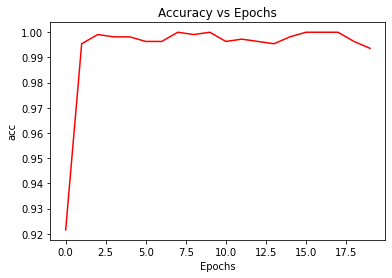

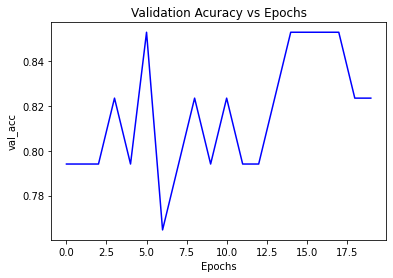

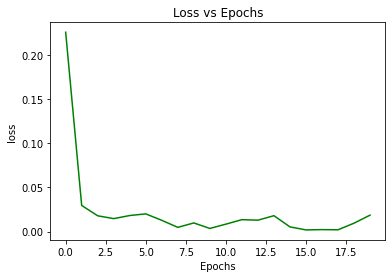

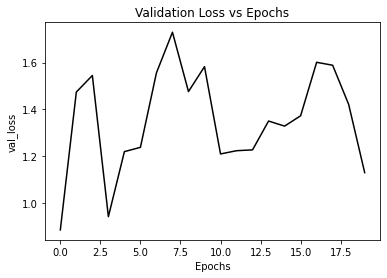

CPU times: user 11min 55s, sys: 2min 56s, total: 14min 51s
Wall time: 16min 11s


In [ ]:
%%time
ax_acl_s_his = model_cor_acl_s.fit(X_Train_cor, Y_Train_cor_acl, epochs = epoch, 
          shuffle=True, validation_split=0.03, batch_size=batchSize)

plot_graphs(ax_acl_s_his)

In [ ]:
model_cor_acl_s.save_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_cor_acl_s.h5')

### Reload model (if alr trained)

In [ ]:
model_cor_acl_sR = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[384, 384, 3]),
    effnet_layer_s,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_cor_acl_sR.load_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_cor_acl_s.h5')

### Test model

In [ ]:
preds_cor_acl_s = model_cor_acl_s.predict(X_Test_cor)

In [ ]:
accuracy_score(Y_Test_cor_acl, np.rint(preds_cor_acl_s).astype(int))

0.6583333333333333

In [ ]:
f1_score(Y_Test_cor_acl, np.rint(preds_cor_acl_s).astype(int), average='binary')

0.4533333333333333

In [ ]:
recall_score(Y_Test_cor_acl, np.rint(preds_cor_acl_s).astype(int), average='binary')

0.3148148148148148

In [ ]:
precision_score(Y_Test_cor_acl, np.rint(preds_cor_acl_s).astype(int), average='binary')

0.8095238095238095

## Model sagittal acl

### Create and train model

In [ ]:
model_sag_acl_s = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[384, 384, 3]),
    effnet_layer_s,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
])

In [ ]:
model_sag_acl_s.compile(loss='binary_crossentropy',
              optimizer='Nadam',metrics=["accuracy"])

Epoch 1/20
69/69 [==============================] - 90s 721ms/step - loss: 0.0954 - accuracy: 0.9699 - val_loss: 1.3213 - val_accuracy: 0.8529
Epoch 2/20
69/69 [==============================] - 46s 667ms/step - loss: 0.0368 - accuracy: 0.9909 - val_loss: 1.4776 - val_accuracy: 0.8529
Epoch 3/20
69/69 [==============================] - 47s 674ms/step - loss: 0.0199 - accuracy: 0.9973 - val_loss: 1.6752 - val_accuracy: 0.8529
Epoch 4/20
69/69 [==============================] - 46s 673ms/step - loss: 0.0122 - accuracy: 1.0000 - val_loss: 1.4701 - val_accuracy: 0.8235
Epoch 5/20
69/69 [==============================] - 47s 674ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 1.4097 - val_accuracy: 0.8529
Epoch 6/20
69/69 [==============================] - 46s 669ms/step - loss: 0.0141 - accuracy: 0.9991 - val_loss: 1.1477 - val_accuracy: 0.8529
Epoch 7/20
69/69 [==============================] - 46s 674ms/step - loss: 0.0085 - accuracy: 0.9991 - val_loss: 1.4028 - val_accuracy: 0.8529

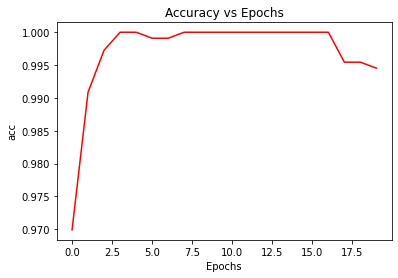

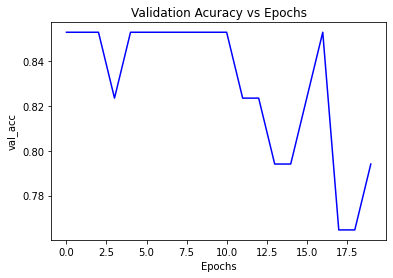

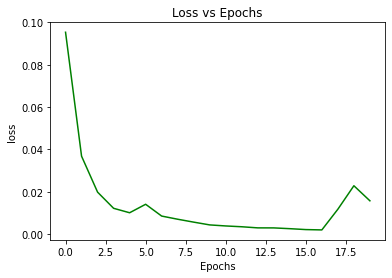

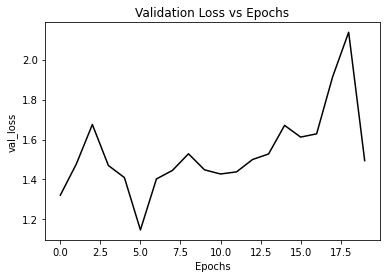

CPU times: user 11min 57s, sys: 2min 56s, total: 14min 54s
Wall time: 17min 2s


In [ ]:
%%time
ax_acl_s_his = model_sag_acl_s.fit(X_Train_sag, Y_Train_sag_acl, epochs = epoch, 
          shuffle=True, validation_split=0.03, batch_size=batchSize)

plot_graphs(ax_acl_s_his)

In [ ]:
model_sag_acl_s.save_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_sag_acl_s.h5')

### Reload model (if alr trained)

In [ ]:
model_sag_acl_sR = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[224, 224, 3]),
    effnet_layer_s,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_sag_acl_sR.load_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_sag_acl_s.h5')

### Test model

In [ ]:
preds_sag_acl_s = model_sag_acl_s.predict(X_Test_sag)

In [ ]:
accuracy_score(Y_Test_sag_acl, np.rint(preds_sag_acl_s).astype(int))

0.6583333333333333

In [ ]:
f1_score(Y_Test_sag_acl, np.rint(preds_sag_acl_s).astype(int), average='binary')

0.40579710144927533

In [ ]:
recall_score(Y_Test_sag_acl, np.rint(preds_sag_acl_s).astype(int), average='binary')

0.25925925925925924

In [ ]:
precision_score(Y_Test_sag_acl, np.rint(preds_sag_acl_s).astype(int), average='binary')

0.9333333333333333

## Overal results

In [ ]:
preds_s = ((np.rint((preds_sag_acl_s+preds_ax_acl_s+preds_cor_acl_s)).astype(int)).astype(bool)).astype(int)

In [ ]:
accuracy_score(labels_test[:,1], preds_s)

0.7916666666666666

In [ ]:
f1_score(labels_test[:,1], preds_s, average='binary')

0.7572815533980582

In [ ]:
precision_score(labels_test[:,1], preds_s, average='binary')

0.7959183673469388

In [ ]:
recall_score(labels_test[:,1], preds_s, average='binary')

0.7222222222222222

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(labels_test[:,1], preds_s)

0.7853535353535355

# EfficientNetv2 B1

In [ ]:
MODEL = 'efficientnetv2-B1'  #@param
effnet_layer_b1 = effnetv2_model.get_model('efficientnetv2-b1')

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [ ]:
epoch = 100
batchSize = 32

In [ ]:
epochs=[0]*epoch
for i in range(0,epoch):
  epochs[i]=i

In [ ]:
X_Train_ax_t = []
X_Train_cor_t = []
X_Train_sag_t = []
X_Test_ax_t = []
X_Test_cor_t = []
X_Test_sag_t = [] 
for i in range(1130):
  img1 = Image.fromarray(X_Train_ax[i,:,:,0])
  img2 = Image.fromarray(X_Train_ax[i,:,:,1])
  img3 = Image.fromarray(X_Train_ax[i,:,:,2])
  img1_ = img1.resize(size = (240,240))
  img2_ = img2.resize(size = (240,240)) 
  img3_ = img3.resize(size = (240,240))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Train_ax_t.append(img_tensor)

  img1 = Image.fromarray(X_Train_cor[i,:,:,0])
  img2 = Image.fromarray(X_Train_cor[i,:,:,1])
  img3 = Image.fromarray(X_Train_cor[i,:,:,2])
  img1_ = img1.resize(size = (240,240))
  img2_ = img2.resize(size = (240,240)) 
  img3_ = img3.resize(size = (240,240))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Train_cor_t.append(img_tensor)

  img1 = Image.fromarray(X_Train_sag[i,:,:,0])
  img2 = Image.fromarray(X_Train_sag[i,:,:,1])
  img3 = Image.fromarray(X_Train_sag[i,:,:,2])
  img1_ = img1.resize(size = (240,240))
  img2_ = img2.resize(size = (240,240)) 
  img3_ = img3.resize(size = (240,240))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Train_sag_t.append(img_tensor)
for i in range(120):
  img1 = Image.fromarray(X_Test_ax[i,:,:,0])
  img2 = Image.fromarray(X_Test_ax[i,:,:,1])
  img3 = Image.fromarray(X_Test_ax[i,:,:,2])
  img1_ = img1.resize(size = (240,240))
  img2_ = img2.resize(size = (240,240)) 
  img3_ = img3.resize(size = (240,240))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Test_ax_t.append(img_tensor)

  img1 = Image.fromarray(X_Test_cor[i,:,:,0])
  img2 = Image.fromarray(X_Test_cor[i,:,:,1])
  img3 = Image.fromarray(X_Test_cor[i,:,:,2])
  img1_ = img1.resize(size = (240,240))
  img2_ = img2.resize(size = (240,240)) 
  img3_ = img3.resize(size = (240,240))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Test_cor_t.append(img_tensor)

  img1 = Image.fromarray(X_Test_sag[i,:,:,0])
  img2 = Image.fromarray(X_Test_sag[i,:,:,1])
  img3 = Image.fromarray(X_Test_sag[i,:,:,2])
  img1_ = img1.resize(size = (240,240))
  img2_ = img2.resize(size = (240,240)) 
  img3_ = img3.resize(size = (240,240))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Test_sag_t.append(img_tensor)


X_Train_ax = np.asarray(X_Train_ax_t)
X_Train_cor = np.asarray(X_Train_cor_t)
X_Train_sag = np.asarray(X_Train_sag_t)
X_Test_ax = np.asarray(X_Test_ax_t)
X_Test_cor = np.asarray(X_Test_cor_t)
X_Test_sag = np.asarray(X_Test_sag_t)

print('Train arrays shape')
print(np.asarray(X_Train_ax).shape)
print(np.asarray(Y_Train_ax).shape)
print(np.asarray(X_Train_cor).shape)
print(np.asarray(Y_Train_cor).shape)
print(np.asarray(X_Train_sag).shape)
print(np.asarray(Y_Train_sag).shape)
print('Test arrays shape')
print(np.asarray(X_Test_ax).shape)
print(np.asarray(Y_Test_ax).shape)
print(np.asarray(X_Test_cor).shape)
print(np.asarray(Y_Test_cor).shape)
print(np.asarray(X_Test_sag).shape)
print(np.asarray(Y_Test_sag).shape)

Train arrays shape
(1130, 240, 240, 3)
(1130, 3)
(1130, 240, 240, 3)
(1130, 3)
(1130, 240, 240, 3)
(1130, 3)
Test arrays shape
(120, 240, 240, 3)
(120, 3)
(120, 240, 240, 3)
(120, 3)
(120, 240, 240, 3)
(120, 3)


## Model axial acl

### Create and train model

In [ ]:
model_ax_acl_b1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[240,240, 3]),
    effnet_layer_b1,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
])

In [ ]:
model_ax_acl_b1.compile(loss='binary_crossentropy',
              optimizer='Nadam',metrics=["accuracy"])

Epoch 1/100
35/35 [==============================] - 46s 378ms/step - loss: 0.6350 - accuracy: 0.7290 - val_loss: 1.2121 - val_accuracy: 0.8529
Epoch 2/100
35/35 [==============================] - 10s 278ms/step - loss: 0.4658 - accuracy: 0.8139 - val_loss: 0.2778 - val_accuracy: 0.8824
Epoch 3/100
35/35 [==============================] - 10s 276ms/step - loss: 0.2921 - accuracy: 0.8878 - val_loss: 0.8225 - val_accuracy: 0.6765
Epoch 4/100
35/35 [==============================] - 10s 273ms/step - loss: 0.2074 - accuracy: 0.9316 - val_loss: 0.7177 - val_accuracy: 0.7353
Epoch 5/100
35/35 [==============================] - 10s 273ms/step - loss: 0.1421 - accuracy: 0.9489 - val_loss: 2.2134 - val_accuracy: 0.5882
Epoch 6/100
35/35 [==============================] - 10s 272ms/step - loss: 0.2459 - accuracy: 0.9106 - val_loss: 0.4101 - val_accuracy: 0.7941
Epoch 7/100
35/35 [==============================] - 9s 271ms/step - loss: 0.1219 - accuracy: 0.9580 - val_loss: 0.5200 - val_accuracy: 

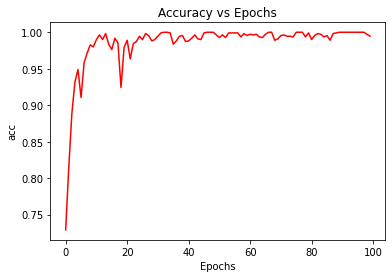

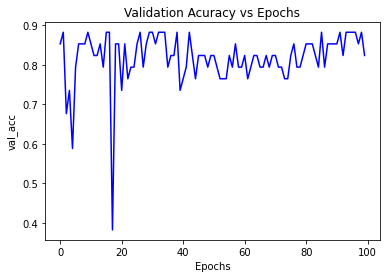

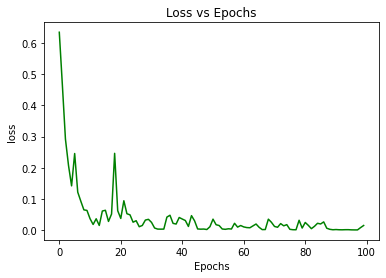

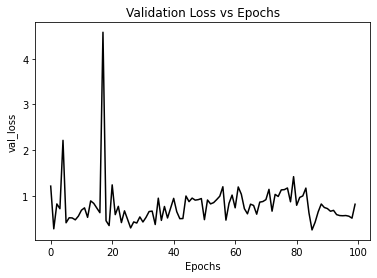

CPU times: user 13min 44s, sys: 2min 11s, total: 15min 55s
Wall time: 16min 46s


In [ ]:
%%time
ax_acl_b1_his = model_ax_acl_b1.fit(X_Train_ax, Y_Train_ax_acl, epochs = epoch, 
          shuffle=True, validation_split=0.03, batch_size=batchSize)

plot_graphs(ax_acl_b1_his)

In [ ]:
model_ax_acl_b1.save_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_ax_acl_b1.h5')

### Reload model (if alr trained)

In [ ]:
model_ax_acl_b1R = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[240,240, 3]),
    effnet_layer_b1,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_ax_acl_b1R.load_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_ax_acl_b1.h5')

### Test model

In [ ]:
preds_ax_acl_b1 = model_ax_acl_b1.predict(X_Test_ax)

In [ ]:
accuracy_score(Y_Test_ax_acl, np.rint(preds_ax_acl_b1).astype(int))

0.7916666666666666

In [ ]:
f1_score(Y_Test_ax_acl, np.rint(preds_ax_acl_b1).astype(int), average='binary')

0.7191011235955056

In [ ]:
recall_score(Y_Test_ax_acl, np.rint(preds_ax_acl_b1).astype(int), average='binary')

0.5925925925925926

In [ ]:
precision_score(Y_Test_ax_acl, np.rint(preds_ax_acl_b1).astype(int), average='binary')

0.9142857142857143

## Model coronal acl

### Create and train model

In [ ]:
model_cor_acl_b1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[240,240, 3]),
    effnet_layer_b1,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
])

In [ ]:
model_cor_acl_b1.compile(loss='binary_crossentropy',
              optimizer='Nadam',metrics=["accuracy"])

Epoch 1/100
35/35 [==============================] - 43s 363ms/step - loss: 0.6981 - accuracy: 0.7144 - val_loss: 0.5362 - val_accuracy: 0.8235
Epoch 2/100
35/35 [==============================] - 9s 260ms/step - loss: 0.5491 - accuracy: 0.7865 - val_loss: 0.5442 - val_accuracy: 0.8529
Epoch 3/100
35/35 [==============================] - 9s 263ms/step - loss: 0.4243 - accuracy: 0.8276 - val_loss: 0.4992 - val_accuracy: 0.7353
Epoch 4/100
35/35 [==============================] - 9s 262ms/step - loss: 0.3035 - accuracy: 0.8869 - val_loss: 0.5163 - val_accuracy: 0.7647
Epoch 5/100
35/35 [==============================] - 9s 263ms/step - loss: 0.2296 - accuracy: 0.9124 - val_loss: 0.6958 - val_accuracy: 0.8529
Epoch 6/100
35/35 [==============================] - 9s 263ms/step - loss: 0.1919 - accuracy: 0.9325 - val_loss: 0.6984 - val_accuracy: 0.8235
Epoch 7/100
35/35 [==============================] - 9s 266ms/step - loss: 0.1449 - accuracy: 0.9471 - val_loss: 1.0064 - val_accuracy: 0.823

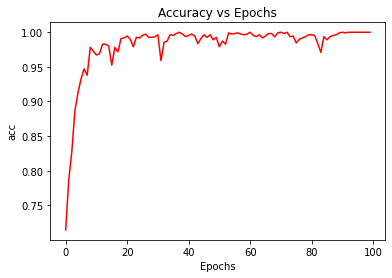

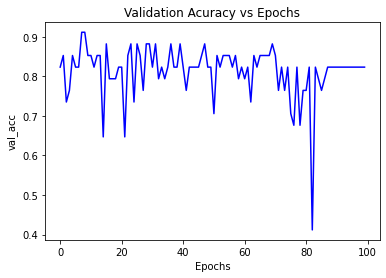

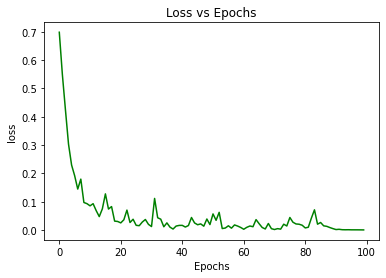

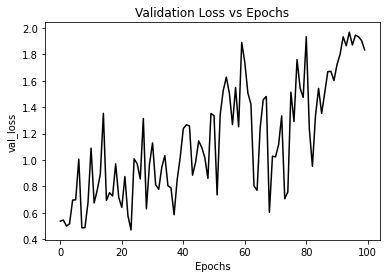

CPU times: user 13min 20s, sys: 2min 5s, total: 15min 25s
Wall time: 16min 46s


In [ ]:
%%time
ax_acl_b1_his = model_cor_acl_b1.fit(X_Train_cor, Y_Train_cor_acl, epochs = epoch, 
          shuffle=True, validation_split=0.03, batch_size=batchSize)

plot_graphs(ax_acl_b1_his)

In [ ]:
model_cor_acl_b1.save_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_cor_acl_b1.h5')

### Reload model (if alr trained)

In [ ]:
model_cor_acl_b1R = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[240,240, 3]),
    effnet_layer_b1,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_cor_acl_b1R.load_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_cor_acl_b1.h5')

### Test model

In [ ]:
preds_cor_acl_b1 = model_cor_acl_b1.predict(X_Test_cor)

In [ ]:
accuracy_score(Y_Test_cor_acl, np.rint(preds_cor_acl_b1).astype(int))

0.675

In [ ]:
f1_score(Y_Test_cor_acl, np.rint(preds_cor_acl_b1).astype(int), average='binary')

0.48

In [ ]:
recall_score(Y_Test_cor_acl, np.rint(preds_cor_acl_b1).astype(int), average='binary')

0.3333333333333333

In [ ]:
precision_score(Y_Test_cor_acl, np.rint(preds_cor_acl_b1).astype(int), average='binary')

0.8571428571428571

## Model sagittal acl

### Create and train model

In [ ]:
model_sag_acl_b1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[240, 240, 3]),
    effnet_layer_b1,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
])

In [ ]:
model_sag_acl_b1.compile(loss='binary_crossentropy',
              optimizer='Nadam',metrics=["accuracy"])

Epoch 1/100
35/35 [==============================] - 37s 345ms/step - loss: 0.6401 - accuracy: 0.7664 - val_loss: 0.5626 - val_accuracy: 0.8529
Epoch 2/100
35/35 [==============================] - 10s 278ms/step - loss: 0.3850 - accuracy: 0.8440 - val_loss: 0.7875 - val_accuracy: 0.5882
Epoch 3/100
35/35 [==============================] - 10s 275ms/step - loss: 0.2319 - accuracy: 0.9170 - val_loss: 0.4530 - val_accuracy: 0.8235
Epoch 4/100
35/35 [==============================] - 10s 274ms/step - loss: 0.1798 - accuracy: 0.9434 - val_loss: 0.6799 - val_accuracy: 0.8235
Epoch 5/100
35/35 [==============================] - 10s 272ms/step - loss: 0.1057 - accuracy: 0.9672 - val_loss: 0.6763 - val_accuracy: 0.8529
Epoch 6/100
35/35 [==============================] - 10s 274ms/step - loss: 0.0711 - accuracy: 0.9818 - val_loss: 1.4422 - val_accuracy: 0.5882
Epoch 7/100
35/35 [==============================] - 10s 272ms/step - loss: 0.1885 - accuracy: 0.9352 - val_loss: 0.7834 - val_accuracy:

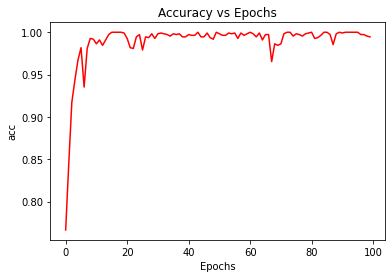

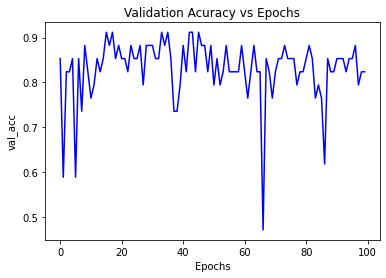

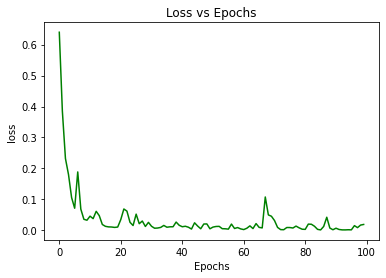

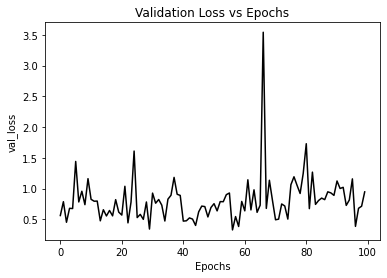

CPU times: user 13min 41s, sys: 2min 9s, total: 15min 50s
Wall time: 16min 47s


In [ ]:
%%time
ax_acl_b1_his = model_sag_acl_b1.fit(X_Train_sag, Y_Train_sag_acl, epochs = epoch, 
          shuffle=True, validation_split=0.03, batch_size=batchSize)

plot_graphs(ax_acl_b1_his)

In [ ]:
model_sag_acl_b1.save_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_sag_acl_b1.h5')

### Reload model (if alr trained)

In [ ]:
model_sag_acl_b1R = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[480, 480, 3]),
    effnet_layer_b1,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_sag_acl_b1R.load_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_sag_acl_b1.h5')

### Test model

In [ ]:
preds_sag_acl_b1 = model_sag_acl_b1.predict(X_Test_sag)

In [ ]:
accuracy_score(Y_Test_sag_acl, np.rint(preds_sag_acl_b1).astype(int))

0.75

In [ ]:
f1_score(Y_Test_sag_acl, np.rint(preds_sag_acl_b1).astype(int), average='binary')

0.6341463414634146

In [ ]:
recall_score(Y_Test_sag_acl, np.rint(preds_sag_acl_b1).astype(int), average='binary')

0.48148148148148145

In [ ]:
precision_score(Y_Test_sag_acl, np.rint(preds_sag_acl_b1).astype(int), average='binary')

0.9285714285714286

## Overal results

In [ ]:
preds_b1 = ((np.rint((preds_sag_acl_b1+preds_ax_acl_b1+preds_cor_acl_b1)).astype(int)).astype(bool)).astype(int)

NameError: ignored

In [ ]:
accuracy_score(labels_test[:,1], preds_b1)

0.8583333333333333

In [ ]:
f1_score(labels_test[:,1], preds_b1, average='binary')

0.8282828282828282

In [ ]:
recall_score(labels_test[:,1], preds_b1, average='binary')

0.7592592592592593

In [ ]:
precision_score(labels_test[:,1], preds_b1, average='binary')

0.9111111111111111

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(labels_test[:,1], preds_b1)

0.8493265993265994

# EfficientNetv2 B3



In [ ]:
MODEL = 'efficientnetv2-B3'  #@param
effnet_layer_b3 = effnetv2_model.get_model('efficientnetv2-b3')

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


In [ ]:
epoch = 100
batchSize = 32

In [ ]:
epochs=[0]*epoch
for i in range(0,epoch):
  epochs[i]=i

In [ ]:
X_Train_ax_t = []
X_Train_cor_t = []
X_Train_sag_t = []
X_Test_ax_t = []
X_Test_cor_t = []
X_Test_sag_t = [] 
for i in range(1130):
  img1 = Image.fromarray(X_Train_ax[i,:,:,0])
  img2 = Image.fromarray(X_Train_ax[i,:,:,1])
  img3 = Image.fromarray(X_Train_ax[i,:,:,2])
  img1_ = img1.resize(size = (300,300))
  img2_ = img2.resize(size = (300,300)) 
  img3_ = img3.resize(size = (300,300))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Train_ax_t.append(img_tensor)

  img1 = Image.fromarray(X_Train_cor[i,:,:,0])
  img2 = Image.fromarray(X_Train_cor[i,:,:,1])
  img3 = Image.fromarray(X_Train_cor[i,:,:,2])
  img1_ = img1.resize(size = (300,300))
  img2_ = img2.resize(size = (300,300)) 
  img3_ = img3.resize(size = (300,300))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Train_cor_t.append(img_tensor)

  img1 = Image.fromarray(X_Train_sag[i,:,:,0])
  img2 = Image.fromarray(X_Train_sag[i,:,:,1])
  img3 = Image.fromarray(X_Train_sag[i,:,:,2])
  img1_ = img1.resize(size = (300,300))
  img2_ = img2.resize(size = (300,300)) 
  img3_ = img3.resize(size = (300,300))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Train_sag_t.append(img_tensor)
for i in range(120):
  img1 = Image.fromarray(X_Test_ax[i,:,:,0])
  img2 = Image.fromarray(X_Test_ax[i,:,:,1])
  img3 = Image.fromarray(X_Test_ax[i,:,:,2])
  img1_ = img1.resize(size = (300,300))
  img2_ = img2.resize(size = (300,300)) 
  img3_ = img3.resize(size = (300,300))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Test_ax_t.append(img_tensor)

  img1 = Image.fromarray(X_Test_cor[i,:,:,0])
  img2 = Image.fromarray(X_Test_cor[i,:,:,1])
  img3 = Image.fromarray(X_Test_cor[i,:,:,2])
  img1_ = img1.resize(size = (300,300))
  img2_ = img2.resize(size = (300,300)) 
  img3_ = img3.resize(size = (300,300))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Test_cor_t.append(img_tensor)

  img1 = Image.fromarray(X_Test_sag[i,:,:,0])
  img2 = Image.fromarray(X_Test_sag[i,:,:,1])
  img3 = Image.fromarray(X_Test_sag[i,:,:,2])
  img1_ = img1.resize(size = (300,300))
  img2_ = img2.resize(size = (300,300)) 
  img3_ = img3.resize(size = (300,300))
  i1 = np.asarray(img1_)
  i2 = np.asarray(img2_)
  i3 = np.asarray(img3_)
  img_tensor = np.dstack((i1,i2,i3)) #(w,h,3)
  X_Test_sag_t.append(img_tensor)


X_Train_ax = np.asarray(X_Train_ax_t)
X_Train_cor = np.asarray(X_Train_cor_t)
X_Train_sag = np.asarray(X_Train_sag_t)
X_Test_ax = np.asarray(X_Test_ax_t)
X_Test_cor = np.asarray(X_Test_cor_t)
X_Test_sag = np.asarray(X_Test_sag_t)

print('Train arrays shape')
print(np.asarray(X_Train_ax).shape)
print(np.asarray(Y_Train_ax).shape)
print(np.asarray(X_Train_cor).shape)
print(np.asarray(Y_Train_cor).shape)
print(np.asarray(X_Train_sag).shape)
print(np.asarray(Y_Train_sag).shape)
print('Test arrays shape')
print(np.asarray(X_Test_ax).shape)
print(np.asarray(Y_Test_ax).shape)
print(np.asarray(X_Test_cor).shape)
print(np.asarray(Y_Test_cor).shape)
print(np.asarray(X_Test_sag).shape)
print(np.asarray(Y_Test_sag).shape)

Train arrays shape
(1130, 300, 300, 3)
(1130, 3)
(1130, 300, 300, 3)
(1130, 3)
(1130, 300, 300, 3)
(1130, 3)
Test arrays shape
(120, 300, 300, 3)
(120, 3)
(120, 300, 300, 3)
(120, 3)
(120, 300, 300, 3)
(120, 3)


## Model axial acl

### Create and train model

In [ ]:
model_ax_acl_b3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[300,300, 3]),
    effnet_layer_b3,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
])

In [ ]:
model_ax_acl_b3.compile(loss='binary_crossentropy',
              optimizer='Nadam',metrics=["accuracy"])

Epoch 1/100
35/35 [==============================] - 64s 759ms/step - loss: 0.6749 - accuracy: 0.7245 - val_loss: 0.3725 - val_accuracy: 0.8235
Epoch 2/100
35/35 [==============================] - 21s 590ms/step - loss: 0.4656 - accuracy: 0.8175 - val_loss: 0.4415 - val_accuracy: 0.8235
Epoch 3/100
35/35 [==============================] - 21s 588ms/step - loss: 0.3891 - accuracy: 0.8422 - val_loss: 0.3550 - val_accuracy: 0.8235
Epoch 4/100
35/35 [==============================] - 21s 592ms/step - loss: 0.2253 - accuracy: 0.9078 - val_loss: 0.6545 - val_accuracy: 0.8529
Epoch 5/100
35/35 [==============================] - 21s 593ms/step - loss: 0.1697 - accuracy: 0.9288 - val_loss: 2.6926 - val_accuracy: 0.5000
Epoch 6/100
35/35 [==============================] - 21s 592ms/step - loss: 0.1998 - accuracy: 0.9188 - val_loss: 0.5478 - val_accuracy: 0.8824
Epoch 7/100
35/35 [==============================] - 21s 591ms/step - loss: 0.1522 - accuracy: 0.9480 - val_loss: 0.4928 - val_accuracy:

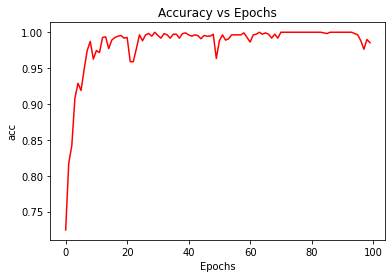

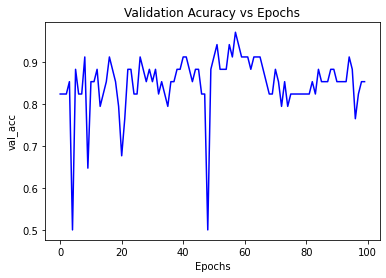

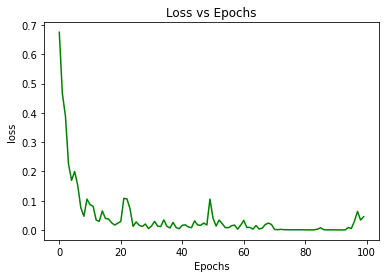

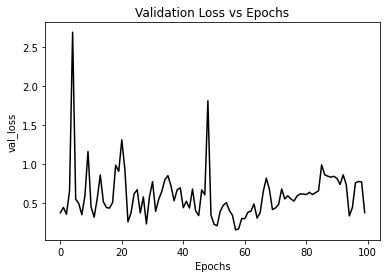

CPU times: user 25min 53s, sys: 6min 19s, total: 32min 12s
Wall time: 35min 52s


In [ ]:
%%time
ax_acl_b3_his = model_ax_acl_b3.fit(X_Train_ax, Y_Train_ax_acl, epochs = epoch, 
          shuffle=True, validation_split=0.03, batch_size=batchSize)

plot_graphs(ax_acl_b3_his)

In [ ]:
model_ax_acl_b3.save_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_ax_acl_b3.h5')

### Reload model (if alr trained)

In [ ]:
model_ax_acl_b3R = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[300,300, 3]),
    effnet_layer_b3,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_ax_acl_b3R.load_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_ax_acl_b3.h5')

### Test model

In [ ]:
preds_ax_acl_b3 = model_ax_acl_b3.predict(X_Test_ax)

In [ ]:
accuracy_score(Y_Test_ax_acl, np.rint(preds_ax_acl_b3).astype(int))

0.8083333333333333

In [ ]:
f1_score(Y_Test_ax_acl, np.rint(preds_ax_acl_b3).astype(int), average='binary')

0.7526881720430108

In [ ]:
recall_score(Y_Test_ax_acl, np.rint(preds_ax_acl_b3).astype(int), average='binary')

0.6481481481481481

In [ ]:
precision_score(Y_Test_ax_acl, np.rint(preds_ax_acl_b3).astype(int), average='binary')

0.8974358974358975

## Model coronal acl

### Create and train model

In [ ]:
model_cor_acl_b3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[300,300, 3]),
    effnet_layer_b3,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
])

In [ ]:
model_cor_acl_b3.compile(loss='binary_crossentropy',
              optimizer='Nadam',metrics=["accuracy"])

Epoch 1/100
35/35 [==============================] - 53s 666ms/step - loss: 0.5968 - accuracy: 0.7828 - val_loss: 0.9449 - val_accuracy: 0.4118
Epoch 2/100
35/35 [==============================] - 21s 597ms/step - loss: 0.5145 - accuracy: 0.7965 - val_loss: 0.6914 - val_accuracy: 0.7941
Epoch 3/100
35/35 [==============================] - 21s 589ms/step - loss: 0.4271 - accuracy: 0.8193 - val_loss: 0.4896 - val_accuracy: 0.7941
Epoch 4/100
35/35 [==============================] - 21s 589ms/step - loss: 0.2886 - accuracy: 0.8859 - val_loss: 0.8851 - val_accuracy: 0.6765
Epoch 5/100
35/35 [==============================] - 21s 596ms/step - loss: 0.2050 - accuracy: 0.9352 - val_loss: 1.1820 - val_accuracy: 0.5588
Epoch 6/100
35/35 [==============================] - 21s 593ms/step - loss: 0.1498 - accuracy: 0.9443 - val_loss: 0.5131 - val_accuracy: 0.8824
Epoch 7/100
35/35 [==============================] - 21s 592ms/step - loss: 0.0983 - accuracy: 0.9617 - val_loss: 0.7810 - val_accuracy:

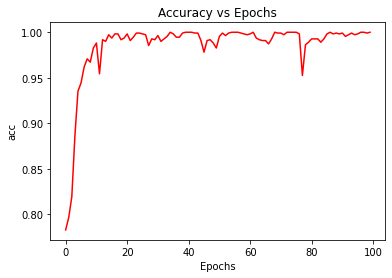

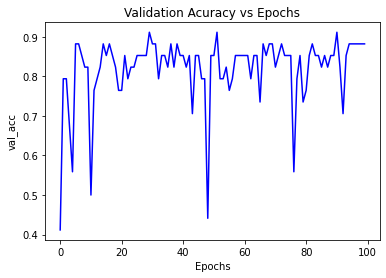

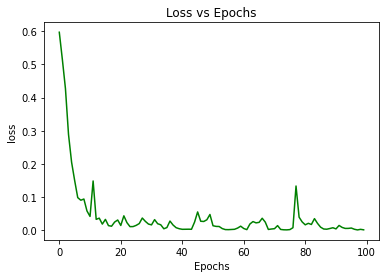

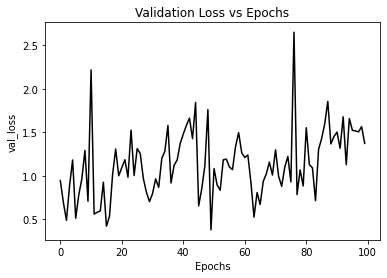

CPU times: user 25min 56s, sys: 6min 13s, total: 32min 9s
Wall time: 35min 11s


In [ ]:
%%time
ax_acl_b3_his = model_cor_acl_b3.fit(X_Train_cor, Y_Train_cor_acl, epochs = epoch, 
          shuffle=True, validation_split=0.03, batch_size=batchSize)

plot_graphs(ax_acl_b3_his)

In [ ]:
model_cor_acl_b3.save_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_cor_acl_b3.h5')

### Reload model (if alr trained)

In [ ]:
model_cor_acl_b3R = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[300,300, 3]),
    effnet_layer_b3,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_cor_acl_b3R.load_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_cor_acl_b3.h5')

### Test model

In [ ]:
preds_cor_acl_b3 = model_cor_acl_b3.predict(X_Test_cor)

In [ ]:
accuracy_score(Y_Test_cor_acl, np.rint(preds_cor_acl_b3).astype(int))

0.6916666666666667

In [ ]:
f1_score(Y_Test_cor_acl, np.rint(preds_cor_acl_b3).astype(int), average='binary')

0.5194805194805194

In [ ]:
recall_score(Y_Test_cor_acl, np.rint(preds_cor_acl_b3).astype(int), average='binary')

0.37037037037037035

In [ ]:
precision_score(Y_Test_cor_acl, np.rint(preds_cor_acl_b3).astype(int), average='binary')

0.8695652173913043

## Model sagittal acl

### Create and train model

In [ ]:
model_sag_acl_b3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[300,300, 3]),
    effnet_layer_b3,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
])

In [ ]:
model_sag_acl_b3.compile(loss='binary_crossentropy',
              optimizer='Nadam',metrics=["accuracy"])

Epoch 1/100
35/35 [==============================] - 54s 662ms/step - loss: 0.6373 - accuracy: 0.7673 - val_loss: 0.3937 - val_accuracy: 0.8529
Epoch 2/100
35/35 [==============================] - 21s 603ms/step - loss: 0.3984 - accuracy: 0.8403 - val_loss: 0.6282 - val_accuracy: 0.6765
Epoch 3/100
35/35 [==============================] - 21s 596ms/step - loss: 0.1748 - accuracy: 0.9398 - val_loss: 0.5617 - val_accuracy: 0.7353
Epoch 4/100
35/35 [==============================] - 21s 588ms/step - loss: 0.0847 - accuracy: 0.9735 - val_loss: 0.6985 - val_accuracy: 0.8235
Epoch 5/100
35/35 [==============================] - 21s 588ms/step - loss: 0.0561 - accuracy: 0.9854 - val_loss: 0.9327 - val_accuracy: 0.7941
Epoch 6/100
35/35 [==============================] - 21s 595ms/step - loss: 0.0481 - accuracy: 0.9863 - val_loss: 0.6624 - val_accuracy: 0.8529
Epoch 7/100
35/35 [==============================] - 21s 595ms/step - loss: 0.0313 - accuracy: 0.9954 - val_loss: 1.0216 - val_accuracy:

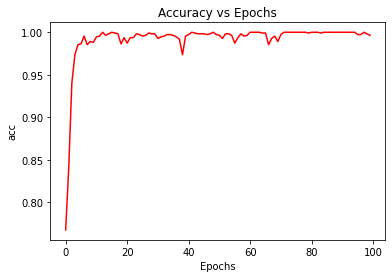

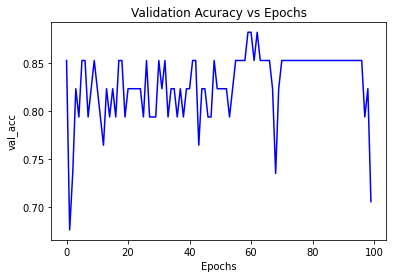

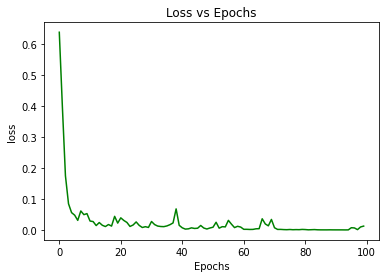

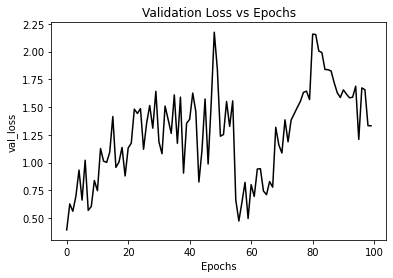

CPU times: user 25min 59s, sys: 6min 10s, total: 32min 9s
Wall time: 35min 53s


In [ ]:
%%time
ax_acl_b3_his = model_sag_acl_b3.fit(X_Train_sag, Y_Train_sag_acl, epochs = epoch, 
          shuffle=True, validation_split=0.03, batch_size=batchSize)

plot_graphs(ax_acl_b3_his)

In [ ]:
model_sag_acl_b2.save_weights('/content/drive/MyDrive/MRNet/Models/model_sag_acl_b2.h5')

### Reload model (if alr trained)

In [ ]:
model_sag_acl_b3R = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[300,300, 3]),
    effnet_layer_b3,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model_sag_acl_b3R.load_weights('/content/drive/MyDrive/Colab Notebooks/MRNet/Models/model_sag_acl_b3.h5')

### Test model

In [ ]:
preds_sag_acl_b3 = model_sag_acl_b3.predict(X_Test_sag)

In [ ]:
accuracy_score(Y_Test_sag_acl, np.rint(preds_sag_acl_b3).astype(int))

0.725

In [ ]:
f1_score(Y_Test_sag_acl, np.rint(preds_sag_acl_b3).astype(int), average='binary')

0.6526315789473683

In [ ]:
recall_score(Y_Test_sag_acl, np.rint(preds_sag_acl_b3).astype(int), average='binary')

0.5740740740740741

In [ ]:
precision_score(Y_Test_sag_acl, np.rint(preds_sag_acl_b3).astype(int), average='binary')

0.7560975609756098

## Overal results

In [ ]:
preds_b3 = ((np.rint((preds_sag_acl_b3+preds_ax_acl_b3+preds_cor_acl_b3)).astype(int)).astype(bool)).astype(int)

In [ ]:
accuracy_score(labels_test[:,1], preds_b3)

0.7916666666666666

In [ ]:
f1_score(labels_test[:,1], preds_b3, average='binary')

0.7787610619469028

In [ ]:
precision_score(labels_test[:,1], preds_b3, average='binary')

0.7457627118644068

In [ ]:
recall_score(labels_test[:,1], preds_b3, average='binary')

0.8148148148148148

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(labels_test[:,1], preds_b3)

0.7937710437710438